<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/HelmerNylen/Lab-7/HelmerNylen_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 7: Optimization and learning**
**Helmer Nylén**

# **Abstract**

In this lab we implement gradient descent and Newton's method for finding the local minima of a function. We test these using quadratic forms, and find that Newton's method is much faster and more accurate than gradient descent.

#**About the code**

In [17]:
"""This program is a lab report in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Helmer Nylén (helmern@kth.se)
# Implementation details were discussed with Jonas Nylund
# Test funcitons were discussed with Christoffer Ejemyr

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
import numpy as np
from scipy.stats import special_ortho_group
from random import randint
from time import time

from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

# **Introduction**

Finding the minima of a function is a basic problem in optimization, which nonetheless has many different types of solution algorithms. In this lab we implement gradient descent and Newton's algorithm and test the implementations on simple functions in $\mathbb{R}^n$.



# **Methods**

## Implementation
We base the gradient descent implementation on algorithm 15.1, chapter 15.2 in the lecture notes. To compute the gradient of $f$ at $x$ we use the central difference $$(\nabla f(x))_i = \frac{f(x + h e_i) - f(x - h e_i)}{2h}.$$
The $\alpha$ is selected by a simple search: $$\alpha = \underset{\alpha\in A}{\operatorname{argmin}} f(x-\alpha \nabla f(x)),$$ where $$A = \{10^i\ :\ i = -1, \ldots, -4\}.$$

In [0]:
def gradient(f, x, h=1e-8):
  n = len(x)
  grad = np.zeros(n)
  for i in range(n):
    e_i = np.arange(n) == i
    grad[i] = (f(x + h * e_i) - f(x - h * e_i)) / (2 * h)
  return grad

_test_alphas = 10 ** (-1 - 3 * np.arange(21) / 20).reshape((-1, 1))
def get_next_x(f, grad, x, alpha_factor):
  xs = x - _test_alphas * grad * alpha_factor
  return xs[np.argmin([f(_x) for _x in xs])]

def gradient_descent(f, initial, alpha_factor=1, tolerance=1e-6, return_all_x=False):
  assert hasattr(f, "__call__")

  x = np.array(initial).ravel()
  if return_all_x:
    all_x = [x]

  grad = gradient(f, x)
  while np.linalg.norm(grad) > tolerance:
    x = get_next_x(f, grad, x, alpha_factor)
    grad = gradient(f, x)

    if return_all_x:
      all_x.append(x)
  
  return np.array(all_x) if return_all_x else x

To implement Newton's method we use algorithm 15.3, chapter 15.2 of the lecture notes. This time we need not only the gradient of our function but also the Hessian matrix. To compute this we use the definition from Wikipedia: $H_{i,j} = \frac{\partial^2 f}{\partial x_i \partial x_j}$. Using the same central difference to compute partial derivatives of the gradient we get
\begin{align}H_{i,j} = \frac{\partial^2 f}{\partial x_i \partial x_j} = \frac{\partial}{\partial x_i} \frac{\partial f}{\partial x_j} &\approx \frac{\partial}{\partial x_i} \frac{f(x+h e_j) - f(x-h e_j)}{2 h} \\ &\approx \frac{\frac{f((x + h e_j)+h e_i) - f((x + h e_j)-h e_i)}{2 h} - \frac{f((x - h e_j)+h e_i) - f((x - h e_j)-h e_i)}{2 h}}{2 h} \\ &= \frac{f(x + h (e_j + e_i)) - f(x + h (e_j- e_i)) - f(x - h (e_j - e_i)) + f(x - h (e_j + e_i))}{4 h^2}.\end{align}

In [0]:
def hessian(f, x, h=1e-6):
  n = len(x)
  hess = np.zeros((n, n))
  for i in range(n):
    e_i = 1 * (np.arange(n) == i)
    for j in range(n):
      e_j = np.arange(n) == j
      s = e_j + e_i
      d = e_j - e_i
      hess[i, j] = (f(x + h*s) - f(x + h*d) - f(x - h*d) + f(x - h*s)) / (4 * h**2)

  return hess

def newtons_method(f, initial, alpha_factor=1, tolerance=1e-6, return_all_x=False):
  assert hasattr(f, "__call__")

  x = np.array(initial).ravel()
  if return_all_x:
    all_x = [x]
  
  grad = gradient(f, x)
  while np.linalg.norm(grad) > tolerance:
    hess = hessian(f, x)
    try:
      dx = np.linalg.solve(hess, grad)
    except np.linalg.LinAlgError:
      break
    #x = get_next_x(f, dx, x, alpha_factor)
    x = x - dx
    grad = gradient(f, x)

    if return_all_x:
      all_x.append(x)
  
  return np.array(all_x) if return_all_x else x

## Visualization
We use the following method to plot a $\mathbb{R}^2 \rightarrow \mathbb{R}$ function and descent paths for the different methods.

In [0]:
def visualize_descent(f, *paths, domain=(-8, 8, -8, 8), mode="spin",
                      show_progress=True, init_angle=30, fps=30, animation_length = 10,
                      title=None, logscale=False, resolution=40):
  paths = tuple(np.array([p for p in path if domain[0] <= p[0] <= domain[1] and domain[2] <= p[1] <= domain[3]]) for path in paths)
  X = np.linspace(domain[0], domain[1], resolution)
  Y = np.linspace(domain[2], domain[3], resolution)
  X, Y = np.meshgrid(X, Y)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  Z = np.array([f(p) for p in np.column_stack((X.ravel(), Y.ravel()))])
  Z = Z.reshape(X.shape)

  surf = ax.scatter3D(X, Y, Z, 'b', s=0.5)
  x0s = []
  pts = []
  xns = []
  if len(paths) > 0:
    for i, path in enumerate(paths):
      x0s.append(ax.plot(path[0:1, 0], path[0:1, 1], f(path[0, :]), 'ro',
                         label="Initial guess" if i == 0 else None)[0])
      if mode == "descent":
        pts.append(ax.plot([], [], [], 'k',
                           label="Descent path" if i == 0 else None)[0])
      else:
        pts.append(ax.plot(path[:, 0], path[:, 1], [f(p) for p in path], 'k',
                           label="Descent path" if i == 0 else None)[0])
      xns.append(ax.plot(path[-2:-1, 0], path[-2:-1, 1], f(path[-1, :]), 'go',
                         label="Final value" if i == 0 else None)[0])
      
    ax.legend(loc="upper right")
  x0s = tuple(x0s)
  pts = tuple(pts)
  xns = tuple(xns)

  ax.set_xlabel("$x$")
  ax.set_ylabel("$y$")
  ax.set_zlabel("$f(x,y)$")
  if logscale:
    ax.set_zscale('log')
  maxlen = max(map(len, paths))

  def _init():
    if mode == "descent":
      for i in range(len(paths)):
        pts[i].set_data([], [])
    
    ax.view_init(30, init_angle)
    return (surf,) + pts + x0s + xns

  def _animate(i):
    if mode == "descent":
      for j, path in enumerate(paths):
        ind = min(len(path), i)
        pts[j].set_data(path[:ind, 0], path[:ind, 1])
        pts[j].set_3d_properties([f(p) for p in path[:ind]])

      if show_progress and i % max(1, maxlen // 10) == 0:
        print(f"{i / maxlen:.0%}", end=" ")
      if show_progress and i == maxlen - 1:
        print(f"{1:.0%}")
    else:
      ax.view_init(30, init_angle + 360 * i / (fps * animation_length))

      if show_progress and i % ((fps * animation_length) // 10) == 0:
        print(f"{i / (fps * animation_length):.0%}", end=" ")
      if show_progress and i == fps * animation_length - 1:
        print(f"{1:.0%}")

    return (surf,) + pts + x0s + xns
  
  if title:
    fig.suptitle(title)
  if mode == "descent":
    a = animation.FuncAnimation(fig, _animate, init_func=_init,
                                frames=maxlen, blit=True,
                                interval=(1000 * animation_length) // maxlen)
  else:
    a = animation.FuncAnimation(fig, _animate, init_func=_init,
                                frames=animation_length * fps, blit=True,
                                interval=1000 / fps)
  plt.close(fig)
  return HTML(a.to_html5_video())

## Testing
To test the methods we use random positive-definite quadratic forms in $\mathbb{R}^n$, where $n \in [2,10]$. We can generate these by taking a random diagonal matrix $L$ with positive entries, a random vector $b$, and using `special_ortho_group` in `scipy` to create random orthogonal matrices $Q$. Letting $A = Q^T L Q$ we know that $A$ is symmetric, and our function $$f(x) = (x-b)^T A (x-b)$$ will have a single minimum at $x=b$.

We look at the residual $x - b$ as a function of iteration number, and also the error $|f(x) - f(b)|$.

We also demonstrate the differences between the methods using a hand-picked function $$f(x) = |x|^2 \sin \sqrt{x_0^2 + \frac{1}{2}x_1^2}.$$

In [0]:
def demo(method):
  f = lambda x: (x[0]**2 + x[1]**2) * np.sin(np.sqrt(x[0]**2 + 0.5 * x[1]**2))
  initials = np.array([[1.5, 2.5], [1, 1], [-2.5, 0]])
  if method == "both":
    descents = {}
    for m in [gradient_descent, newtons_method]:
      descents[m] = tuple(m(f, initial, return_all_x=True)
                  for initial in initials)
    print("Animating")
    print(f"GD lengths: {list(map(len, descents[gradient_descent]))}")
    print(f"Newton lengths: {list(map(len, descents[newtons_method]))}")
    display(visualize_descent(f, *(descents[gradient_descent] + descents[newtons_method]),
                              mode="spin", title="Newton's method and Gradient Descent"))
    
  else:
    descents = [method(f, initial, return_all_x=True)
                  for initial in initials]
    print("Animating")
    print(f"Lengths: {list(map(len, descents))}")
    display(visualize_descent(f, *descents, mode="spin", title=method.__name__))
    display(visualize_descent(f, descents[0], descents[1][:150], descents[2],
                              mode="descent", init_angle = 120, title=method.__name__))

# https://en.wikipedia.org/wiki/Definite_quadratic_form
def test(method, plot=False):
  ndim = 2 if plot else randint(2, 10)
  lower = -np.ones(ndim)
  upper = np.ones(ndim)
  Q = special_ortho_group.rvs(ndim)
  L = np.diag(np.random.rand(ndim))
  A = Q.transpose() @ L @ Q
  b = lower + np.random.rand(ndim) * (upper - lower)
  f = lambda x: ((x - b).reshape((1, -1)) @ A @ (x - b))[0]
  
  initial = lower + np.random.rand(ndim) * (upper - lower)
  descent = method(f, initial, return_all_x=True)
  final = descent[-1, :]
  if plot:
    print(f"Descent length: {descent.shape[0]}")
    print("Animating: ", end="")
    display(visualize_descent(f, descent,
                              domain=np.column_stack((lower, upper)).ravel(),
                              mode="spin"))
    plt.figure()
    plt.semilogy(np.linalg.norm(descent - b, axis=1))
    plt.xlabel("Iteration")
    plt.ylabel("$|x_{approx} - x_{exact}|$")
    plt.title("Convergence of residual")
    plt.show()
  
  return [np.isclose(np.linalg.norm(final - b), 0, atol=10 ** -i) for i in range(1, 7)]

# **Results**

## Gradient Descent

Descent length: 135
Animating: 0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


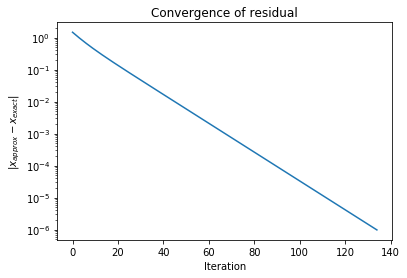

Testing: 0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%
Passed 1e-1: 100.0%
Passed 1e-2: 100.0%
Passed 1e-3: 100.0%
Passed 1e-4: 97.6%
Passed 1e-5: 72.4%
Passed 1e-6: 7.2%
Total test time: 189.704 s


In [23]:
test(gradient_descent, True)
iterations = 500
passed = [0] * 6
print("Testing: ", end="")
start = time()
for i in range(iterations):
  for j, p in enumerate(test(gradient_descent)):
    passed[j] += p

  if i % (iterations // 10) == 0:
    print(f"{i / iterations:.0%}", end=" ")
  if i == iterations - 1:
    print(f"{1:.0%}")

for i in range(1, 7):
  print(f"Passed 1e-{i}: {passed[i-1] / iterations:.1%}")

print(f"Total test time: {time() - start:.3f} s")

We can see in the figure above that the residual decreases exponentially. In all test cases the final $x$ is within $10^{-3}$ of the exact solution, and in a majority of test cases it is within $10^{-5}$.

## Newton's Method

Descent length: 3
Animating: 0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


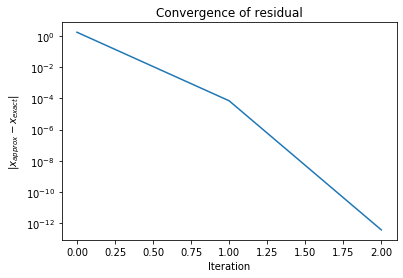

Testing: 0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%
Passed 1e-1: 100.0%
Passed 1e-2: 100.0%
Passed 1e-3: 100.0%
Passed 1e-4: 100.0%
Passed 1e-5: 99.8%
Passed 1e-6: 99.2%
Total test time: 2.171 s


In [24]:
test(newtons_method, True)
iterations = 500
passed = [0] * 6
print("Testing: ", end="")
start = time()
for i in range(iterations):
  for j, p in enumerate(test(newtons_method)):
    passed[j] += p

  if i % (iterations // 10) == 0:
    print(f"{i / iterations:.0%}", end=" ")
  if i == iterations - 1:
    print(f"{1:.0%}")

for i in range(1, 7):
  print(f"Passed 1e-{i}: {passed[i-1] / iterations:.1%}")

print(f"Total test time: {time() - start:.3f} s")

As Newton's method converges very fast we only have three data points in the figure above, and thus it is hard to draw any conclusions about the exact convergence rate. We do note, however, that it is both much faster and more accurate than gradient descent. Almost all test cases have a final $x$ within $10^{-6}$ of the exact solution, and the results are acquired about 100 times as fast (comparing runtime rather than iteration steps).

## Difference demonstration

In [25]:
demo(gradient_descent)
demo("both")

Animating
Lengths: [131, 6782, 10]
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


Animating
GD lengths: [131, 6782, 10]
Newton lengths: [7, 11, 4]
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


The first two animations show gradient descent on the function $$f(x) = |x|^2 \sin \sqrt{x_0^2 + \frac{1}{2}x_1^2}$$ using the initial values $\begin{bmatrix}1.5 \\ 2.5\end{bmatrix}$, $\begin{bmatrix}1 \\ 1\end{bmatrix}$ and $\begin{bmatrix}-2.5 \\ 0\end{bmatrix}$. The last plot shows both gradient descent and Newton's method on the same problem. The first initial value causes both methods to reach the same local minimum using very different paths. Similarly, using the second initial value both methods find the same local minimum (in 0) and seem to follow a similar path in space (though the gradient descent takes many more iterations to get there). The last initial value causes gradient descent to find a saddle point, as the gradient in y is 0 along the entire path, but Newton's method instead finds a maximum along the ridge.

# **Discussion**

We conclude that the implementations likely are correct, though we have not tested extensively with functions that have several local extrema. Newton's method is faster than gradient descent but finds any type of extrema, not just minima, so careful initialization is needed. Using improper or unlucky initial values gradient descent can accidentally find saddle points, but in the general case it only finds minima.

Testing was only done with positive-definite quadratic forms. It can be extended to test negative-definite, semidefinite or indefinite quadratic forms by changing the eigenvalues of $A$ in $L$. Gradient descent needs to be modified to find maxima (which can be as easy as flipping the sign of $f$) and will perform poorly if attempting to find saddle points, but Newton's method should in theory work on all three.